In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from config.model_config import ModelConfig
from config.experiment_config import ExperimentConfig, AvailableDatasets
from vol_predict.features.preprocessor import OneToOnePreprocessor
from vol_predict.loss.loss import Loss

from vol_predict.models.dl.transformer_predictor import TransformerPredictor as Model
from vol_predict.models.dl.lstm_softplus_predictor import (
    LSTMSoftplusPredictor as Baseline,
)

from run import run_backtest, initialize_runner

In [3]:
config = ExperimentConfig()
config.DATASET = AvailableDatasets.BITCOIN

model_params = ModelConfig()
baseline_params = ModelConfig()

model_params.n_features = 1200
model_params.n_unique_features = 10

# Handles the features
feature_processor = OneToOnePreprocessor()

runner = initialize_runner(
    model_config=model_params,
    preprocessor=feature_processor,
    experiment_config=config,
)

Train data on 2018-06-05 00:00:00 to 2018-08-31 22:00:00
Test data on 2018-09-15 01:00:00 to 2018-09-30 21:00:00
Num Train Iterations: 1939
Num Features: 1212


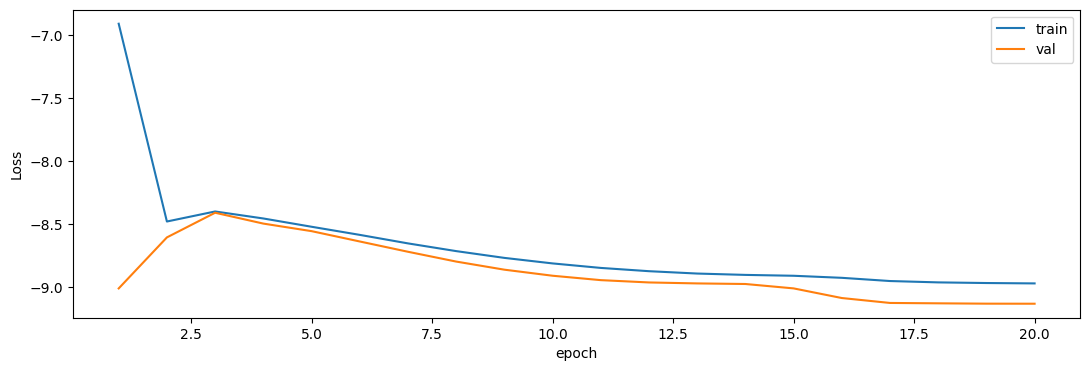

In [4]:
runner.model_config.lr = 1e-2
runner.model_config.n_epochs = 20
runner.model_config.hidden_size = 64
runner.model_config.n_layers = 3
runner.model_config.batch_size = 16
runner.model_config.optimizer = torch.optim.Adam
runner.model_config.loss = Loss.NLL
runner.model_config.dropout = 0.20

result, model, baseline = run_backtest(
    model_cls=Model,
    baseline_cls=Baseline,
    runner=runner,
)

In [5]:
result

RunResult(model_result=AssessmentResult:
* mean_model_loss = -8.687046
* mean_val_loss = -8.687046
* mean_pred_vol = 0.0120465699583292
* mean_true_vol = 0.008140272460877895
* RMSEVolLoss = 0.000127049017, baseline_result=AssessmentResult:
* mean_model_loss = -9.498972
* mean_val_loss = -9.498972
* mean_pred_vol = 0.006886233109980822
* mean_true_vol = 0.008140272460877895
* RMSEVolLoss = 0.000101324178)

In [6]:
model

TransformerPredictor(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=11, out_features=11, bias=True)
    )
    (linear1): Linear(in_features=11, out_features=2048, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=2048, out_features=11, bias=True)
    (norm1): LayerNorm((11,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((11,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=11, out_features=11, bias=True)
        )
        (linear1): Linear(in_features=11, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (line

In [7]:
from config.experiment_config import ExperimentConfig
from config.model_config import ModelConfig

from vol_predict.base.returns import Returns

model_config = ModelConfig()
experiment_config = ExperimentConfig()

data = pd.read_csv(experiment_config.PATH_DATA / experiment_config.DATASET.value)
data["datetime"] = pd.to_datetime(data["datetime"])
data = data.sort_values(by="datetime")
data = data.set_index("datetime")
data.index = data.index.tz_localize(None)
returns = Returns(data.loc[:, experiment_config.RETURN_COLUMN].iloc[1:])

vols = data.loc[:, experiment_config.VOL_COLUMN].iloc[1:]

feature_columns = data.columns.difference(
    [experiment_config.RETURN_COLUMN, experiment_config.VOL_COLUMN]
).tolist()
features = data[feature_columns].shift(1).iloc[1:]

In [8]:
from vol_predict.features.preprocessor import OneToOnePreprocessor
preprocessor = OneToOnePreprocessor()

past_returns = returns.log_returns.shift(1).iloc[1:]
past_vols = vols.shift(1).iloc[1:]

features = features.iloc[1:]
past_returns = returns.log_returns.shift(1).iloc[1:]
true_returns = returns.log_returns.iloc[1:]
true_vols = vols.iloc[1:]

features = preprocessor.transform(features)

features = torch.Tensor(features.to_numpy()).to(torch.float32)
past_returns = torch.Tensor([past_returns]).to(torch.float32)
past_vols = torch.Tensor([past_vols]).to(torch.float32)

true_returns = torch.Tensor([true_returns]).to(torch.float32)
true_vols = torch.Tensor([true_vols]).to(torch.float32)

/var/folders/sr/lzvmv9j54ks_jl4x99t250r00000gn/T/ipykernel_11012/3346976714.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  past_returns = torch.Tensor([past_returns]).to(torch.float32)
/var/folders/sr/lzvmv9j54ks_jl4x99t250r00000gn/T/ipykernel_11012/3346976714.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  past_vols = torch.Tensor([past_vols]).to(torch.float32)
/var/folders/sr/lzvmv9j54ks_jl4x99t250r00000gn/T/ipykernel_11012/3346976714.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

In [9]:
features.shape, past_returns.shape, past_vols.shape

(torch.Size([2577, 1212]), torch.Size([1, 2577]), torch.Size([1, 2577]))

In [10]:
_, _, loader = runner._get_dataloaders()

In [11]:
# X_test = loader

In [12]:
X_test = (features, past_returns.T, past_vols.T)

In [13]:
features.shape

torch.Size([2577, 1212])

In [14]:
past_returns.T.shape, past_vols.T.shape

(torch.Size([2577, 1]), torch.Size([2577, 1]))

In [18]:
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

# ig = IntegratedGradients(lambda feat: model(past_returns.to("mps")[100:], past_vols.to("mps")[100:], feat))
fa = FeatureAblation(lambda feat: model(past_returns.T.to("mps")[100:], past_vols.T.to("mps")[100:], feat))

ig_attr_test = fa.attribute(features.to("mps")[100:])

/Users/buchkovv/mlfcs/vol_predict/models/dl/transformer_predictor.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_final = torch.tensor(pos_final).to(device)


In [22]:
f = data[feature_columns].shift(1).iloc[1:]

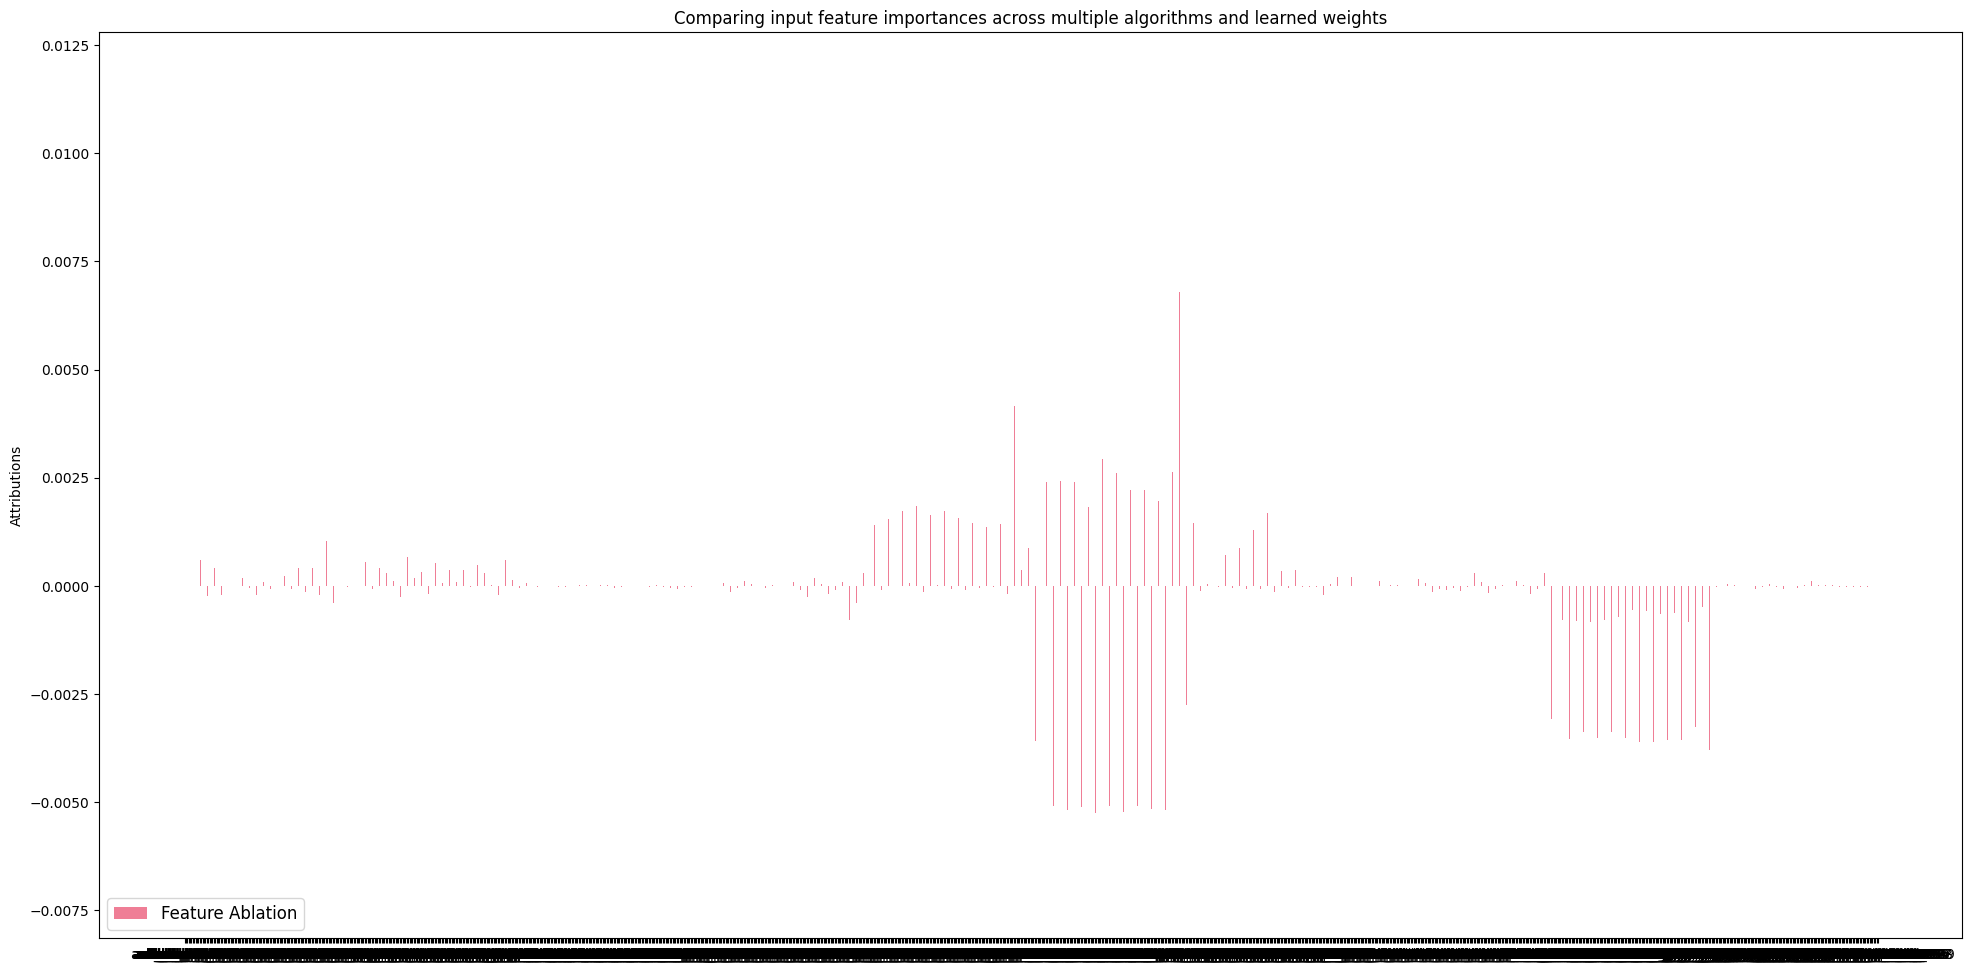

In [24]:
import numpy as np
import matplotlib.pyplot as plt

x_axis_data = np.arange(f.shape[1])
x_axis_data_labels = list(map(lambda idx: f.columns[idx], x_axis_data))

fa_attr_test_sum = ig_attr_test.detach().cpu().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, fa_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

In [28]:
top = np.argsort(fa_attr_test_norm_sum)[-20:]

TypeError: only integer scalar arrays can be converted to a scalar index

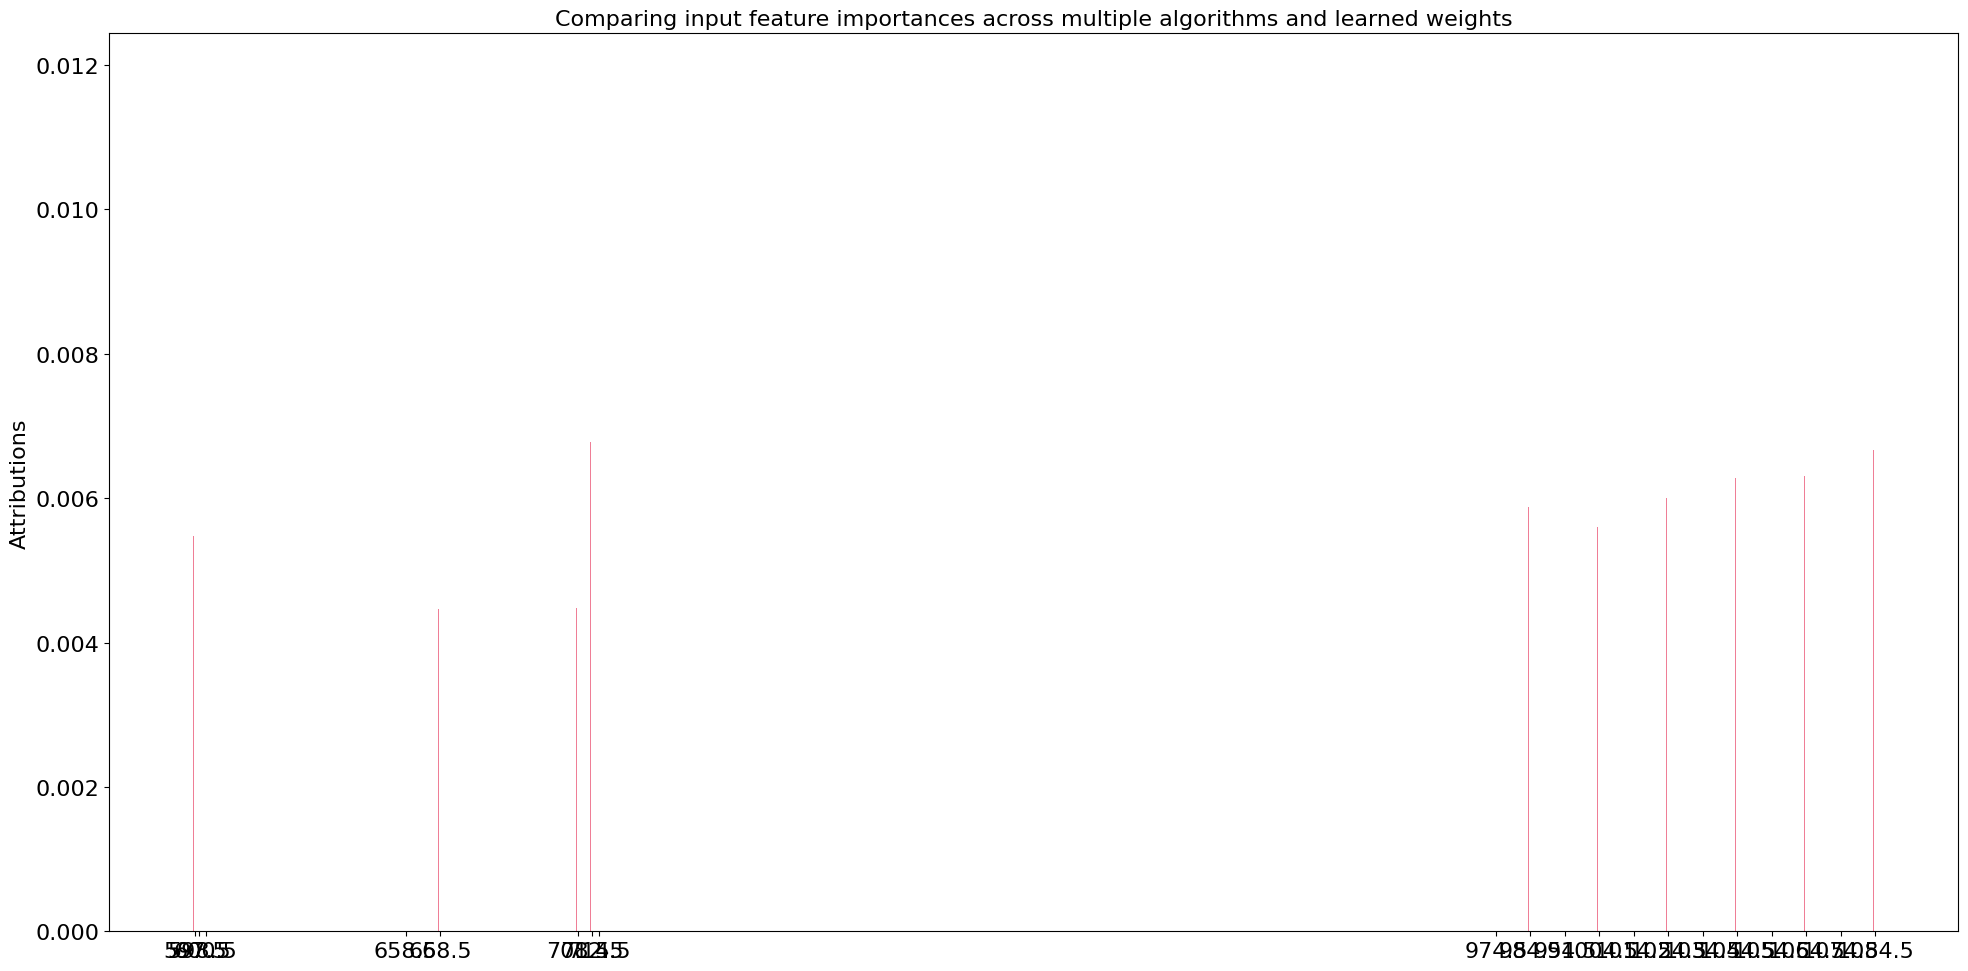

In [30]:
import numpy as np
import matplotlib.pyplot as plt

width = 0.14
legends = ['Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data[top], fa_attr_test_norm_sum[top], width, align='center', alpha=0.8, color='#eb5e7c')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data[top] + 0.5)
ax.set_xticklabels(x_axis_data_labels[top])

plt.legend(legends, loc=3)
plt.show()

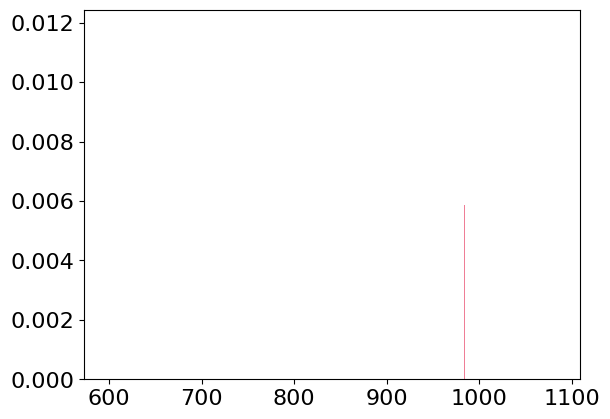

In [31]:
plt.bar(x_axis_data[top], fa_attr_test_norm_sum[top], width, align='center', alpha=0.8, color='#eb5e7c')
plt.show()

In [32]:
fa_attr_test_norm_sum[top]

array([0.00446342, 0.00447201, 0.00477855, 0.00547471, 0.00560649,
       0.00587292, 0.00599039, 0.00600758, 0.00611073, 0.00615657,
       0.00628264, 0.00630556, 0.00648034, 0.00654051, 0.00658349,
       0.00666371, 0.00678118, 0.0098265 , 0.011531  , 0.01184615],
      dtype=float32)

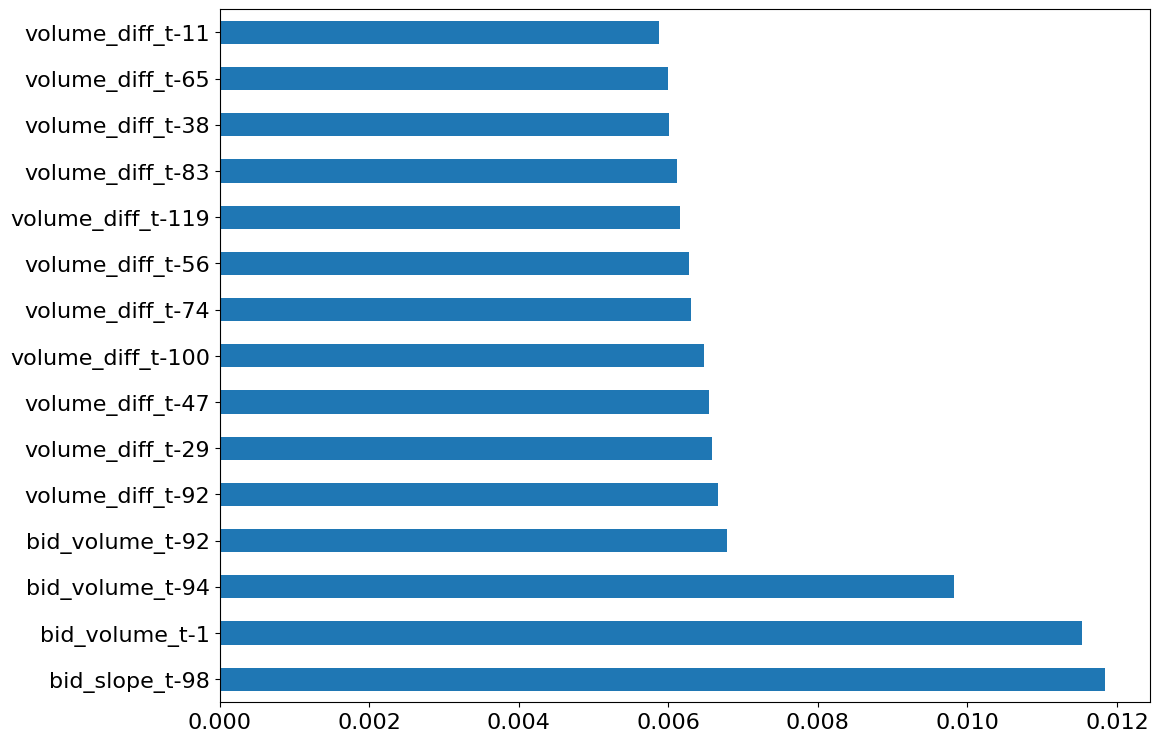

In [39]:
feat_importances = pd.Series(fa_attr_test_norm_sum, index=f.columns)
feat_importances.nlargest(15).plot(kind='barh', figsize=(12, 9));